<a href="https://colab.research.google.com/github/codesalotl/curly-parakeet/blob/main/forRespiratorySounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive

# Constant
SAMPLE_RATE = 22050  # Standard sampling rate for librosa
DURATION = 5  # Target duration of each audio clip in seconds
NUM_CLASSES = 8  # Number of possible diagnoses
IMG_SIZE = 224  # Target image size for MobileNetV3

# Mount Google Drive
drive.mount('/content/drive')

# Paths
DATASET_PATH = '/content/drive/My Drive/_datasets/respiratory-sounds/Respiratory_Sound_Database/Respiratory_Sound_Database/'
AUDIO_PATH = os.path.join(DATASET_PATH, 'audio_and_txt_files')
LABELS_PATH = os.path.join(DATASET_PATH, 'patient_diagnosis.csv')

def load_and_preprocess_audio(file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Ensure audio is of consistent length
    if len(audio) > SAMPLE_RATE * DURATION:
        audio = audio[:SAMPLE_RATE * DURATION]
    else:
        pad_width = SAMPLE_RATE * DURATION - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')

    # Convert audio to spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Print the shape for debugging
    print(f'Spectrogram shape before resizing: {spectrogram.shape}')

    # Add batch dimension and convert to 4D tensor
    spectrogram = np.expand_dims(spectrogram, axis=-1)  # shape: (height, width, 1)
    spectrogram = np.expand_dims(spectrogram, axis=0)  # shape: (1, height, width, 1)

    # Resize the spectrogram to the size expected by MobileNetV3
    spectrogram_resized = tf.image.resize(spectrogram, (IMG_SIZE, IMG_SIZE))

    # Convert to 3 channels to match MobileNetV3's input expectations
    spectrogram_resized = tf.image.grayscale_to_rgb(spectrogram_resized)

    # Print the shape for debugging
    print(f'Spectrogram shape after resizing: {spectrogram_resized.shape}')

    return spectrogram_resized.numpy()  # Convert tensor to numpy array



# Function to load labels
def load_labels(labels_path):
    labels = {}
    with open(labels_path, 'r') as f:
        for line in f:
            patient_id, diagnosis = line.strip().split(',')
            labels[patient_id] = diagnosis
    return labels

# Load labels
labels = load_labels(LABELS_PATH)

# Map diagnoses to integers
diagnosis_to_int = {
    'URTI': 0, 'Healthy': 1, 'Asthma': 2, 'COPD': 3,
    'LRTI': 4, 'Bronchiectasis': 5, 'Pneumonia': 6, 'Bronchiolitis': 7
}
int_to_diagnosis = {v: k for k, v in diagnosis_to_int.items()}

# Load and preprocess data
X, y = [], []

for file_name in os.listdir(AUDIO_PATH):
    if file_name.endswith('.wav'):
        patient_id = file_name.split('_')[0]
        if patient_id in labels:
            # Load and preprocess the audio file
            file_path = os.path.join(AUDIO_PATH, file_name)
            spectrogram = load_and_preprocess_audio(file_path)

            # Append to dataset
            X.append(spectrogram)
            y.append(diagnosis_to_int[labels[patient_id]])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# One-hot encode labels
y = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Free memory by deleting unused variables
del X, y

# Step 2: Model Building
# Load MobileNetV3 Small model without the top layers
base_model = MobileNetV3Small(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze the base model layers to prevent them from being trained
base_model.trainable = False

# Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Step 3: Model Training
# Define the path where the models will be saved
save_path_h5 = '/content/drive/My Drive/_datasets/respiratory-sounds/respiratory_sound_classifier.h5'
save_path_keras = '/content/drive/My Drive/_datasets/respiratory-sounds/respiratory_sound_classifier.keras'

# Define callbacks for early stopping and saving the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(save_path_h5, save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=callbacks)

# Save the final model in both .h5 and .keras formats
model.save(save_path_h5)  # Saving in .h5 format
model.save(save_path_keras)  # Saving in .keras format

# Step 4: Model Evaluation
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 1, 224, 224, 3)


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from google.colab import drive

# Constants
SAMPLE_RATE = 22050  # Standard sampling rate for librosa
DURATION = 5  # Target duration of each audio clip in seconds
NUM_CLASSES = 8  # Number of possible diagnoses
IMG_SIZE = 224  # Target image size for MobileNetV3

# Mount Google Drive
drive.mount('/content/drive')

# Paths
DATASET_PATH = '/content/drive/My Drive/_datasets/respiratory-sounds/Respiratory_Sound_Database/Respiratory_Sound_Database/'
AUDIO_PATH = os.path.join(DATASET_PATH, 'audio_and_txt_files')
LABELS_PATH = os.path.join(DATASET_PATH, 'patient_diagnosis.csv')

# Function to load and preprocess audio files
def load_and_preprocess_audio(file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Ensure audio is of consistent length
    if len(audio) > SAMPLE_RATE * DURATION:
        audio = audio[:SAMPLE_RATE * DURATION]
    else:
        pad_width = SAMPLE_RATE * DURATION - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')

    # Convert audio to spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Print the shape for debugging
    print(f'Spectrogram shape before resizing: {spectrogram.shape}')

    # Add batch dimension and convert to 4D tensor
    spectrogram = np.expand_dims(spectrogram, axis=-1)  # shape: (height, width, 1)
    spectrogram = np.expand_dims(spectrogram, axis=0)  # shape: (1, height, width, 1)

    # Resize the spectrogram to the size expected by MobileNetV3
    spectrogram_resized = tf.image.resize(spectrogram, (IMG_SIZE, IMG_SIZE))

    # Convert to 3 channels to match MobileNetV3's input expectations
    spectrogram_resized = tf.image.grayscale_to_rgb(spectrogram_resized)

    # Print the shape for debugging
    print(f'Spectrogram shape after resizing: {spectrogram_resized.shape}')

    return spectrogram_resized.numpy().squeeze(0)  # Remove batch dimension before returning

# Function to load labels
def load_labels(labels_path):
    labels = {}
    with open(labels_path, 'r') as f:
        for line in f:
            patient_id, diagnosis = line.strip().split(',')
            labels[patient_id] = diagnosis
    return labels

# Load labels
labels = load_labels(LABELS_PATH)

# Map diagnoses to integers
diagnosis_to_int = {
    'URTI': 0, 'Healthy': 1, 'Asthma': 2, 'COPD': 3,
    'LRTI': 4, 'Bronchiectasis': 5, 'Pneumonia': 6, 'Bronchiolitis': 7
}
int_to_diagnosis = {v: k for k, v in diagnosis_to_int.items()}

# Load and preprocess data
X, y = [], []

for file_name in os.listdir(AUDIO_PATH):
    if file_name.endswith('.wav'):
        patient_id = file_name.split('_')[0]
        if patient_id in labels:
            # Load and preprocess the audio file
            file_path = os.path.join(AUDIO_PATH, file_name)
            spectrogram = load_and_preprocess_audio(file_path)

            # Append to dataset
            X.append(spectrogram)
            y.append(diagnosis_to_int[labels[patient_id]])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# One-hot encode labels
y = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Free memory by deleting unused variables
del X, y

# Step 2: Model Building
# Load MobileNetV3 Small model without the top layers
base_model = MobileNetV3Small(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze the base model layers to prevent them from being trained
base_model.trainable = False

# Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Step 3: Model Training
# Define the path where the models will be saved
save_path_h5 = '/content/drive/My Drive/_datasets/respiratory-sounds/model01.h5'
save_path_keras = '/content/drive/My Drive/_datasets/respiratory-sounds/model01.keras'

# Define callbacks for early stopping and saving the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(save_path_h5, save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=callbacks)

# Save the final model in both .h5 and .keras formats
model.save(save_path_h5)  # Saving in .h5 format
model.save(save_path_keras)  # Saving in .keras format

# Step 4: Model Evaluation
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3)
Spectrogram shape before resizing: (128, 216)
Spectrogram shape after resizing: (1, 224, 224, 3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 6s 161ms/step - loss: 0.9828 - accuracy: 0.7585 - val_loss: 0.5865 - val_accuracy: 0.8851
Epoch 2/30
19/19 [==============================] - 2s 101ms/step - loss: 0.6128 - accuracy: 0.8605 - val_loss: 0.5061 - val_accuracy: 0.8851
Epoch 3/30
19/19 [==============================] - 2s 97ms/step - loss: 0.5375 - accuracy: 0.8605 - val_loss: 0.4689 - val_accuracy: 0.8851
Epoch 4/30
19/19 [==============================] - 2s 94ms/step - loss: 0.4935 - accuracy: 0.8605 - val_loss: 0.4464 - val_accuracy: 0.8851
Epoch 5/30
19/19 [==============================] - 2s 94ms/step - loss: 0.4558 - accuracy: 0.8622 - val_loss: 0.4260 - val_accuracy: 0.8851
Epoch 6/30
19/19 [==============================] - 2s 93ms/step - loss: 0.4187 - accuracy: 0.8690 - val_loss: 0.4138 - val_accuracy: 0.8784
Epoch 7/30
19/19 [==============================] - 2s 90ms/step - loss: 0.3916 - accuracy: 0.8656 - val_loss: 0.3994 - val_accuracy: 0.8851
Epoch 8/30
19/19 [====

In [ ]:
import numpy as np
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Function to load and preprocess the audio file (same as used during training)
def load_and_preprocess_audio(file_path):
    import librosa
    import tensorflow as tf
    SAMPLE_RATE = 22050
    DURATION = 5
    IMG_SIZE = 224

    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    if len(audio) > SAMPLE_RATE * DURATION:
        audio = audio[:SAMPLE_RATE * DURATION]
    else:
        pad_width = SAMPLE_RATE * DURATION - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')

    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    spectrogram = np.expand_dims(spectrogram, axis=-1)  # (height, width, 1)
    spectrogram = np.expand_dims(spectrogram, axis=0)  # (1, height, width, 1)

    spectrogram_resized = tf.image.resize(spectrogram, (IMG_SIZE, IMG_SIZE))
    spectrogram_resized = tf.image.grayscale_to_rgb(spectrogram_resized)

    return spectrogram_resized.numpy().squeeze(0)  # Remove batch dimension

# Load the model
model_path = '/content/drive/My Drive/_datasets/respiratory-sounds/model01.keras'
model = tf.keras.models.load_model(model_path)

# Path to the audio file you want to predict
file_path = '/content/drive/My Drive/_datasets/respiratory-sounds/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav'

# Preprocess the audio file
input_data = load_and_preprocess_audio(file_path)

# Add batch dimension
input_data = np.expand_dims(input_data, axis=0)  # shape: (1, height, width, channels)

# Make predictions
predictions = model.predict(input_data)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Map the class index to the class label
int_to_diagnosis = {0: 'URTI', 1: 'Healthy', 2: 'Asthma', 3: 'COPD',
                    4: 'LRTI', 5: 'Bronchiectasis', 6: 'Pneumonia', 7: 'Bronchiolitis'}
predicted_label = int_to_diagnosis[predicted_class_index]

print(f'Predicted Diagnosis: {predicted_label}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 1s 822ms/step
Predicted Diagnosis: URTI


In [ ]:
import numpy as np
import tensorflow as tf
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# Function to load and preprocess the audio file (same as used during training)
def load_and_preprocess_audio(file_path):
    import librosa
    import tensorflow as tf
    SAMPLE_RATE = 22050
    DURATION = 5
    IMG_SIZE = 224

    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    if len(audio) > SAMPLE_RATE * DURATION:
        audio = audio[:SAMPLE_RATE * DURATION]
    else:
        pad_width = SAMPLE_RATE * DURATION - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')

    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    spectrogram = np.expand_dims(spectrogram, axis=-1)  # (height, width, 1)
    spectrogram = np.expand_dims(spectrogram, axis=0)  # (1, height, width, 1)

    spectrogram_resized = tf.image.resize(spectrogram, (IMG_SIZE, IMG_SIZE))
    spectrogram_resized = tf.image.grayscale_to_rgb(spectrogram_resized)

    return spectrogram_resized.numpy().squeeze(0)  # Remove batch dimension

# Load the model
model_path = '/content/drive/My Drive/_datasets/respiratory-sounds/model01.keras'
model = tf.keras.models.load_model(model_path)

# Path to the audio file you want to predict
file_path = '/content/drive/My Drive/_datasets/respiratory-sounds/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav'

# Preprocess the audio file
input_data = load_and_preprocess_audio(file_path)

# Add batch dimension
input_data = np.expand_dims(input_data, axis=0)  # shape: (1, height, width, channels)

# Make predictions
predictions = model.predict(input_data)

# Get the probabilities for each class
predicted_probabilities = predictions[0]  # shape: (NUM_CLASSES,)

# Map the class index to the class label
int_to_diagnosis = {0: 'URTI', 1: 'Healthy', 2: 'Asthma', 3: 'COPD',
                    4: 'LRTI', 5: 'Bronchiectasis', 6: 'Pneumonia', 7: 'Bronchiolitis'}

# Display the probability distribution in a formatted way
print("**Probability Distribution**:")
for idx, diagnosis in int_to_diagnosis.items():
    print(f"- {diagnosis}: {predicted_probabilities[idx] * 100:.2f}%")


1/1 [==============================] - 1s 771ms/step
**Probability Distribution**:
- URTI: 0.09%
- Healthy: 0.09%
- Asthma: 0.00%
- COPD: 99.52%
- LRTI: 0.07%
- Bronchiectasis: 0.02%
- Pneumonia: 0.03%
- Bronchiolitis: 0.18%


Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

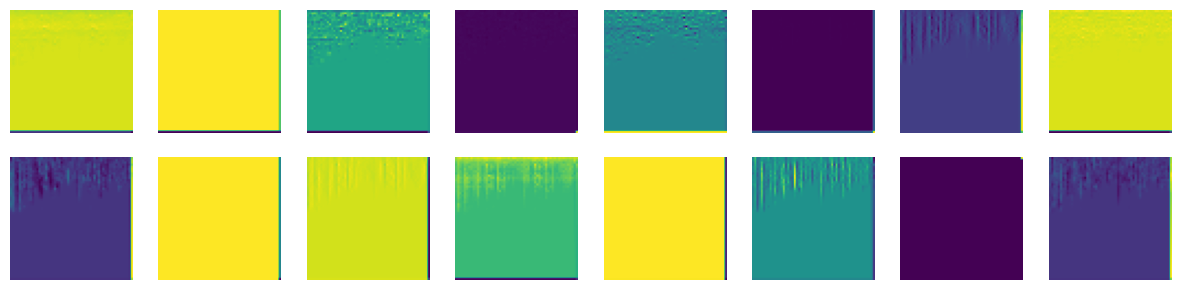

In [ ]:
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt

# Function to load and preprocess the audio file
def load_and_preprocess_audio(file_path):
    SAMPLE_RATE = 22050
    DURATION = 5
    IMG_SIZE = 224

    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    if len(audio) > SAMPLE_RATE * DURATION:
        audio = audio[:SAMPLE_RATE * DURATION]
    else:
        pad_width = SAMPLE_RATE * DURATION - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')

    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    spectrogram = np.expand_dims(spectrogram, axis=-1)  # (height, width, 1)
    spectrogram = np.expand_dims(spectrogram, axis=0)  # (1, height, width, 1)

    spectrogram_resized = tf.image.resize(spectrogram, (IMG_SIZE, IMG_SIZE))
    spectrogram_resized = tf.image.grayscale_to_rgb(spectrogram_resized)

    return spectrogram_resized.numpy().squeeze(0)  # Remove batch dimension

# Load the model
model_path = '/content/drive/My Drive/_datasets/respiratory-sounds/model01.keras'
model = tf.keras.models.load_model(model_path)

# Extract the base model
base_model = model.get_layer('MobilenetV3small')

# Print the summary of the base model to find convolutional layer names
base_model.summary()

# Path to the audio file you want to predict
file_path = '/content/drive/My Drive/_datasets/respiratory-sounds/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav'

# Preprocess the audio file
input_data = load_and_preprocess_audio(file_path)

# Add batch dimension
input_data = np.expand_dims(input_data, axis=0)  # shape: (1, height, width, channels)

# Make predictions
predictions = model.predict(input_data)

# Get the probabilities for each class
predicted_probabilities = predictions[0]  # shape: (NUM_CLASSES,)

# Map the class index to the class label
int_to_diagnosis = {0: 'URTI', 1: 'Healthy', 2: 'Asthma', 3: 'COPD',
                    4: 'LRTI', 5: 'Bronchiectasis', 6: 'Pneumonia', 7: 'Bronchiolitis'}

# Display the probability distribution
print("**Probability Distribution**:")
for idx, diagnosis in int_to_diagnosis.items():
    print(f"- {diagnosis}: {predicted_probabilities[idx] * 100:.2f}%")

# Function to create a model for extracting feature maps from the base model
def create_feature_map_model(base_model, layer_name):
    intermediate_layer_model = tf.keras.Model(inputs=base_model.input,
                                              outputs=base_model.get_layer(layer_name).output)
    return intermediate_layer_model

# Function to visualize feature maps
def visualize_feature_maps(base_model, input_image, layer_name):
    intermediate_model = create_feature_map_model(base_model, layer_name)
    feature_maps = intermediate_model.predict(input_image)

    num_filters = feature_maps.shape[-1]
    size = feature_maps.shape[1]

    plt.figure(figsize=(15, 15))
    for i in range(min(num_filters, 64)):  # Limit the number of filters displayed
        plt.subplot(8, 8, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

# Print all layer names to find a suitable convolutional layer
print("MobileNetV3Small Layer Names:")
for layer in base_model.layers:
    print(layer.name)

# Choose a convolutional layer to visualize from MobileNetV3Small
layer_to_visualize = 'expanded_conv/depthwise'  # Replace this with a suitable layer name

# Visualize feature maps
visualize_feature_maps(base_model, input_data, layer_to_visualize)


In [ ]:
# Load the model
model_path = '/content/drive/My Drive/_datasets/respiratory-sounds/model01.keras'
model = tf.keras.models.load_model(model_path)

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 1014008 (3.87 MB)
Trainable params: 74888 

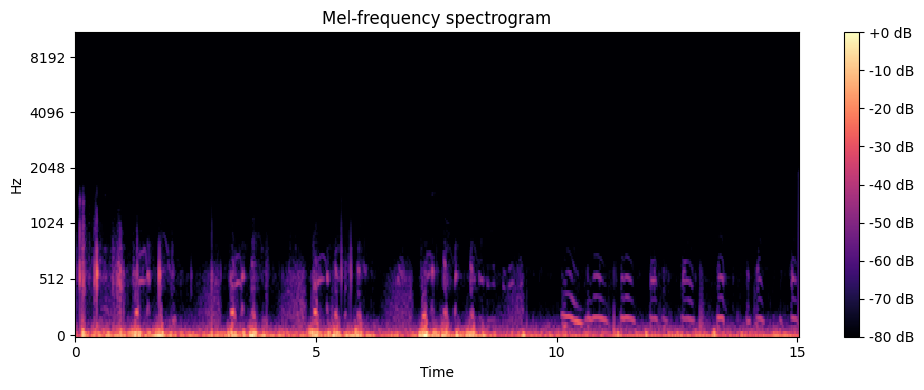

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
file_path = '/content/drive/My Drive/_datasets/respiratory-sounds/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav'
y, sr = librosa.load(file_path)

# Generate the Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Assuming you have a pre-trained Keras model saved as 'model.h5'
# Load the Keras model
model = tf.keras.models.load_model('/content/drive/My Drive/_datasets/respiratory-sounds/model01.keras')

# Define the path where you want to save the TensorFlow.js model
tfjs_target_dir = '/content/drive/My Drive/_datasets/respiratory-sounds/model01-keras'

# Convert the Keras model to TensorFlow.js format
tfjs.converters.save_keras_model(model, tfjs_target_dir)

print(f"Model saved to {tfjs_target_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/My Drive/_datasets/respiratory-sounds/model01-keras


In [ ]:
!pip list

In [ ]:
!pip install tensorflowjs==4.17.0
!pip install tensorflow==2.15.0
!pip install tensorflow-decision-forests==1.8.1